In [1]:
!pip install transformers
!pip install -U spacy
!python3 -m spacy download en_core_web_sm
!pip install wordcloud
!pip install datasets
!pip install -q -U google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.5
    Uninstalling spacy-3.7.5:
      Successfully uninstalled spacy-3.7.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# 라이브러리 임포트
import os
import random
import re
import time
import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import spacy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#import torch_xla
#import torch_xla.core.xla_model as xm

from wordcloud import WordCloud

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, BertConfig

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.sequence import pad_sequences

2024-08-23 12:15:57.032044: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 12:15:57.032178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 12:15:57.186353: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
# 하이퍼파라미터
args = {
    "train_path" : "/kaggle/input/2024-outta-basic-p-2/train.csv",      # train 데이터 경로
    "test_path" : "/kaggle/input/2024-outta-basic-p-2/test.csv",       # test 데이터 경로
    "submit_path" : "/kaggle/input/2024-outta-basic-p-2/sample_submission.csv",     # submit 파일 경로
    "max_len" : 128,
    "batch_size" : 32,
    "num_labels" : 2,
    "epochs" : 6,
    "lr" : 2e-5, 
    "eps" : 1e-8,
    "seed_val" : 42
}

In [6]:
# 랜덤시드 고정하기
seed = args["seed_val"]
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available() : 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 디바이스 선택
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
#!nvidia-smi

In [8]:
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
#os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"  # Set the GPUs 2 and 3 to use

In [9]:
#print(torch.cuda.is_available(), torch.cuda.current_device(), torch.cuda.device_count())
#cuda가 사용 가능하면 true를 반환함으로서 device에 cuda를 설정하도록 한다.

#torch.cuda.current_device()
#현재 cuda가 사용할 GPU를 명시한다.

#torch.cuda.device_count()
#현재 cuda가 사용할 GPU 개수를 명시한다.

In [10]:
if torch.backends.mps.is_available() is True:
    device = torch.device('mps')
    print(f"device : {device}")

# **1. 데이터**

## **(1) 데이터 불러오기**

In [11]:
train = pd.read_csv(args["train_path"])
test = pd.read_csv(args["test_path"])

## **(2) 데이터 시각화 및 분석**

### **1) 데이터 확인**

In [12]:
train.head()
# label로 사용될 fraudulent(true or false)가 가장 마지막 column, 

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,2413,Mystery Shopper,"US, IN, Indianapolis",NaN,NaN,SDI Marketing started in 1988 as a small marke...,"Would you like to travel to Madison, IN for a ...",- You MUST have a Smart Phone with a camera &a...,NaN,0,1,0,Temporary,Entry level,High School or equivalent,Marketing and Advertising,Other,0
1,10961,Intern,"US, NY, New York",NaN,NaN,We’ve built revolutionary technology that is c...,Via is looking for exceptional individuals to ...,NaN,NaN,0,1,1,Other,Not Applicable,NaN,Internet,Other,0
2,14274,Talent Acquisition Specialist USA,"US, NY, New York",People Operations,NaN,Founded in 2010 by a team from Google’s London...,Qubit: Cutting Edge Big Data EngineeringQubit ...,What you’ll needBy submitting your application...,Plenty of perksAs well as the opportunity to s...,0,1,1,Full-time,Associate,Bachelor's Degree,Internet,Human Resources,0
3,4123,Chief Operating Officer,"GB, ,",NaN,NaN,MarketInvoice is one of the most high-profile ...,"Since launching in February 2011, #URL_b577e00...",The Candidate5-10 years full system developmen...,Highly Competitive + Benefits + Bonus for over...,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,9579,Client Manager,"GB, ENG, London",NaN,28000-28000,"Founded by Daniel Tenner and Paulina Sygulska,...",GrantTree provides a financial boost to some o...,NaN,NaN,0,1,0,Full-time,NaN,NaN,Financial Services,NaN,0


In [13]:
test.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
0,4709,Python Engineer,"GB, , London",NaN,NaN,NaN,Stylect is a dynamic startup that helps helps ...,We don’t care where you studied or what your G...,We are negotiable on salary and there is the p...,0,1,0,Full-time,Entry level,Unspecified,Apparel & Fashion,Information Technology
1,11080,Entry Level Sales,"US, OH, Cincinnati",NaN,55000-75000,NaN,General Summary: Achieves maximum sales profit...,NaN,Great Health and DentalFast Advancement Opport...,1,0,0,Full-time,Entry level,High School or equivalent,Financial Services,Sales
2,12358,Agile Project Manager,"US, NY, New York",NaN,NaN,ustwo offers you the opportunity to be yoursel...,"At ustwo™ you get to be yourself, whilst deliv...",Skills• Experience interfacing directly with c...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN
3,14512,Marketing Coordinator,"GB, GBN, London",Business:Marketing,NaN,"We build software for fashion retailers, to he...",About EDITDEDITD runs the world's biggest appa...,Required Skills / Experience:Ability to analys...,NaN,0,1,0,Full-time,NaN,NaN,NaN,Marketing
4,16692,Full-stack Web Engineer,"US, CA, San Francisco",NaN,NaN,Runscope is building tools for developers work...,As a Web Engineer at Runscope you'll be respon...,Extensive front-end web experience (HTML/CSS/J...,Be a part of an experienced team who have work...,0,1,1,Full-time,Mid-Senior level,NaN,NaN,Engineering


In [14]:
train['description'][4]

'GrantTree provides a financial boost to some of the UK’s most innovative startups and tech companies by helping them make the most of government funding schemes.Our mission is to let startups be startups. We push the scene to be more open, transparent, and effective, taking on the bureaucratic burden to let them focus on what matters.We are growing rapidly, having just moved into our new office in Shoreditch and need the help of new team members. We are looking for people with an eye for detail, a talent for clear and prompt communication, and an agile mind that can switch from task to task quickly.The position:You will focus on guiding clients through the various stages needed to file claims for funding. This involves dealing with senior individuals (often CEOs, CTOs and CFOs) in these companies to understand their tech and financials before working with the GrantTree team (and some spreadsheets!) to help compile this information.You will quickly become an expert in government fundin

### **2) 결괏값 분석**

In [15]:
# fraudulent의 mean이 굉장히 0에 가깝다 -> 0이 많다 : 대부분 false 즉, 대부분 직업은 진짜다.

train.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,12516.000000,12516.000000,12516.000000,12516.000000,12516.000000
mean,8944.904522,0.042985,0.800575,0.488655,0.047539
std,5161.238415,0.202831,0.399584,0.499891,0.212798
min,2.000000,0.000000,0.000000,0.000000,0.000000
25%,4481.750000,0.000000,1.000000,0.000000,0.000000
50%,8947.500000,0.000000,1.000000,0.000000,0.000000
75%,13430.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
test.describe()

,job_id,telecommuting,has_company_logo,has_questions
count,5364.000000,5364.000000,5364.000000,5364.000000
mean,8930.222782,0.042692,0.782998,0.498881
std,5163.095978,0.202181,0.412243,0.500045
min,1.000000,0.000000,0.000000,0.000000
25%,4449.750000,0.000000,1.000000,0.000000
50%,8929.500000,0.000000,1.000000,0.000000
75%,13347.250000,0.000000,1.000000,1.000000
max,17879.000000,1.000000,1.000000,1.000000


### **3) 결측치**

In [17]:
train.isnull().sum()

job_id                     0
title                      0
location                 249
department              8058
salary_range           10518
company_profile         2259
description                0
requirements            1878
benefits                5049
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         2433
required_experience     4910
required_education      5670
industry                3394
function                4481
fraudulent                 0
dtype: int64

In [18]:
test.isnull().sum()

job_id                    0
title                     0
location                 97
department             3489
salary_range           4494
company_profile        1049
description               1
requirements            818
benefits               2163
telecommuting             0
has_company_logo          0
has_questions             0
employment_type        1038
required_experience    2140
required_education     2435
industry               1509
function               1974
dtype: int64

In [19]:
# (1) 결측값(NaN)을 공백 문자열로 채움
train.fillna(' ', inplace=True)
test.fillna(' ', inplace=True)

In [20]:
# 모든 결측치 제거 확인
train.isnull().sum(), test.isnull().sum()

(job_id                 0
 title                  0
 location               0
 department             0
 salary_range           0
 company_profile        0
 description            0
 requirements           0
 benefits               0
 telecommuting          0
 has_company_logo       0
 has_questions          0
 employment_type        0
 required_experience    0
 required_education     0
 industry               0
 function               0
 fraudulent             0
 dtype: int64,
 job_id                 0
 title                  0
 location               0
 department             0
 salary_range           0
 company_profile        0
 description            0
 requirements           0
 benefits               0
 telecommuting          0
 has_company_logo       0
 has_questions          0
 employment_type        0
 required_experience    0
 required_education     0
 industry               0
 function               0
 dtype: int64)

In [21]:
print(f'train shape : {train.shape}')
print(f'test shape : {test.shape}')

train shape : (12516, 18)
test shape : (5364, 17)


In [22]:
"""
train.sort_values(by=['fraudulent'], axis=0,inplace = True)

for step, item in enumerate(train['fraudulent'].to_list()):
    if item == 1:
        print(step)
        break
# true : 11921, false : 12516 - 11921 = 595

train.drop(index=train.index[11921:], axis=0)

train.drop(index=train.index[595:], axis=0)

train.drop(index=train.index[:11921], axis=0)

# 1: 3비율
train = pd.concat([train.drop(index=train.index[595:], axis=0),train.drop(index=train.index[:11921-595*2], axis=0)],axis=0, ignore_index=True)

"""

"\ntrain.sort_values(by=['fraudulent'], axis=0,inplace = True)\n\nfor step, item in enumerate(train['fraudulent'].to_list()):\n    if item == 1:\n        print(step)\n        break\n# true : 11921, false : 12516 - 11921 = 595\n\ntrain.drop(index=train.index[11921:], axis=0)\n\ntrain.drop(index=train.index[595:], axis=0)\n\ntrain.drop(index=train.index[:11921], axis=0)\n\n# 1: 3비율\ntrain = pd.concat([train.drop(index=train.index[595:], axis=0),train.drop(index=train.index[:11921-595*2], axis=0)],axis=0, ignore_index=True)\n\n"

### **4) 예측 클래스(fraudulent) 분포**

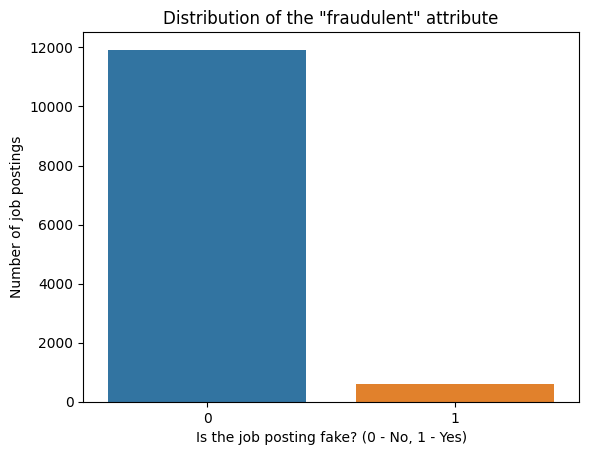

In [23]:
sns.countplot(x='fraudulent',data=train)
plt.title('Distribution of the "fraudulent" attribute')
plt.xlabel('Is the job posting fake? (0 - No, 1 - Yes)')
plt.ylabel('Number of job postings')
plt.show()

### **5) 열 항목값들과 예측 클래스(fraudulent) 사이의 관계 확인**

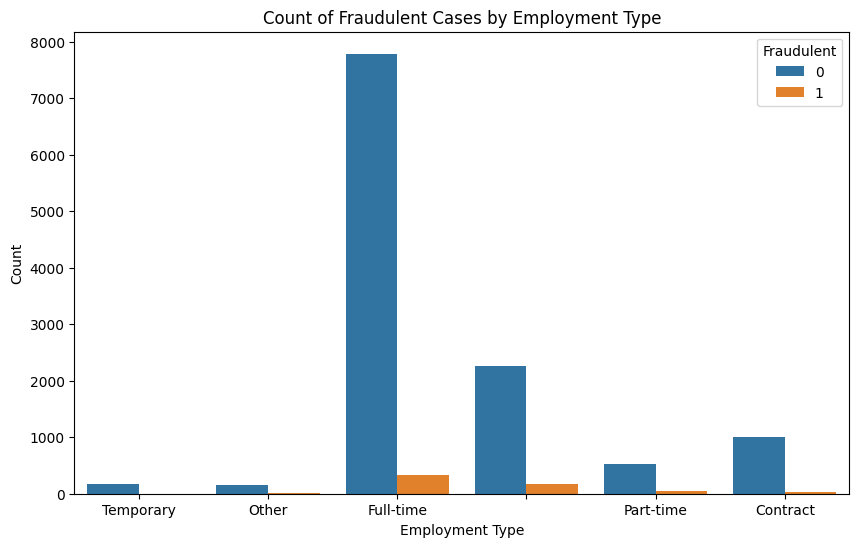

In [24]:
# 대상 계층과 고용 유형 간에 관계가 있는지 확인
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='employment_type', hue='fraudulent')
plt.title('Count of Fraudulent Cases by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Count')
plt.legend(title='Fraudulent')
plt.show()

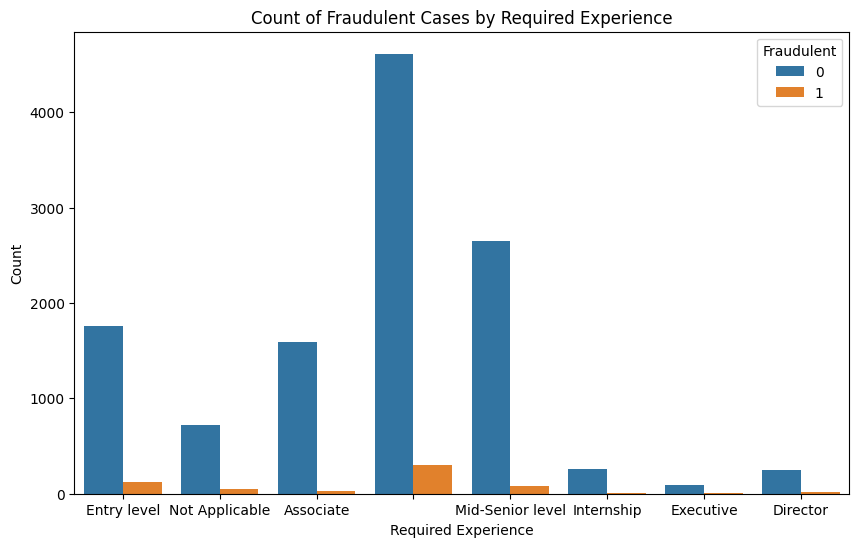

In [25]:
# 대상 클래스와 필수 경험 간에 관계가 있는지 확인
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='required_experience', hue='fraudulent')
plt.title('Count of Fraudulent Cases by Required Experience')
plt.xlabel('Required Experience')
plt.ylabel('Count')
plt.legend(title='Fraudulent')
plt.show()

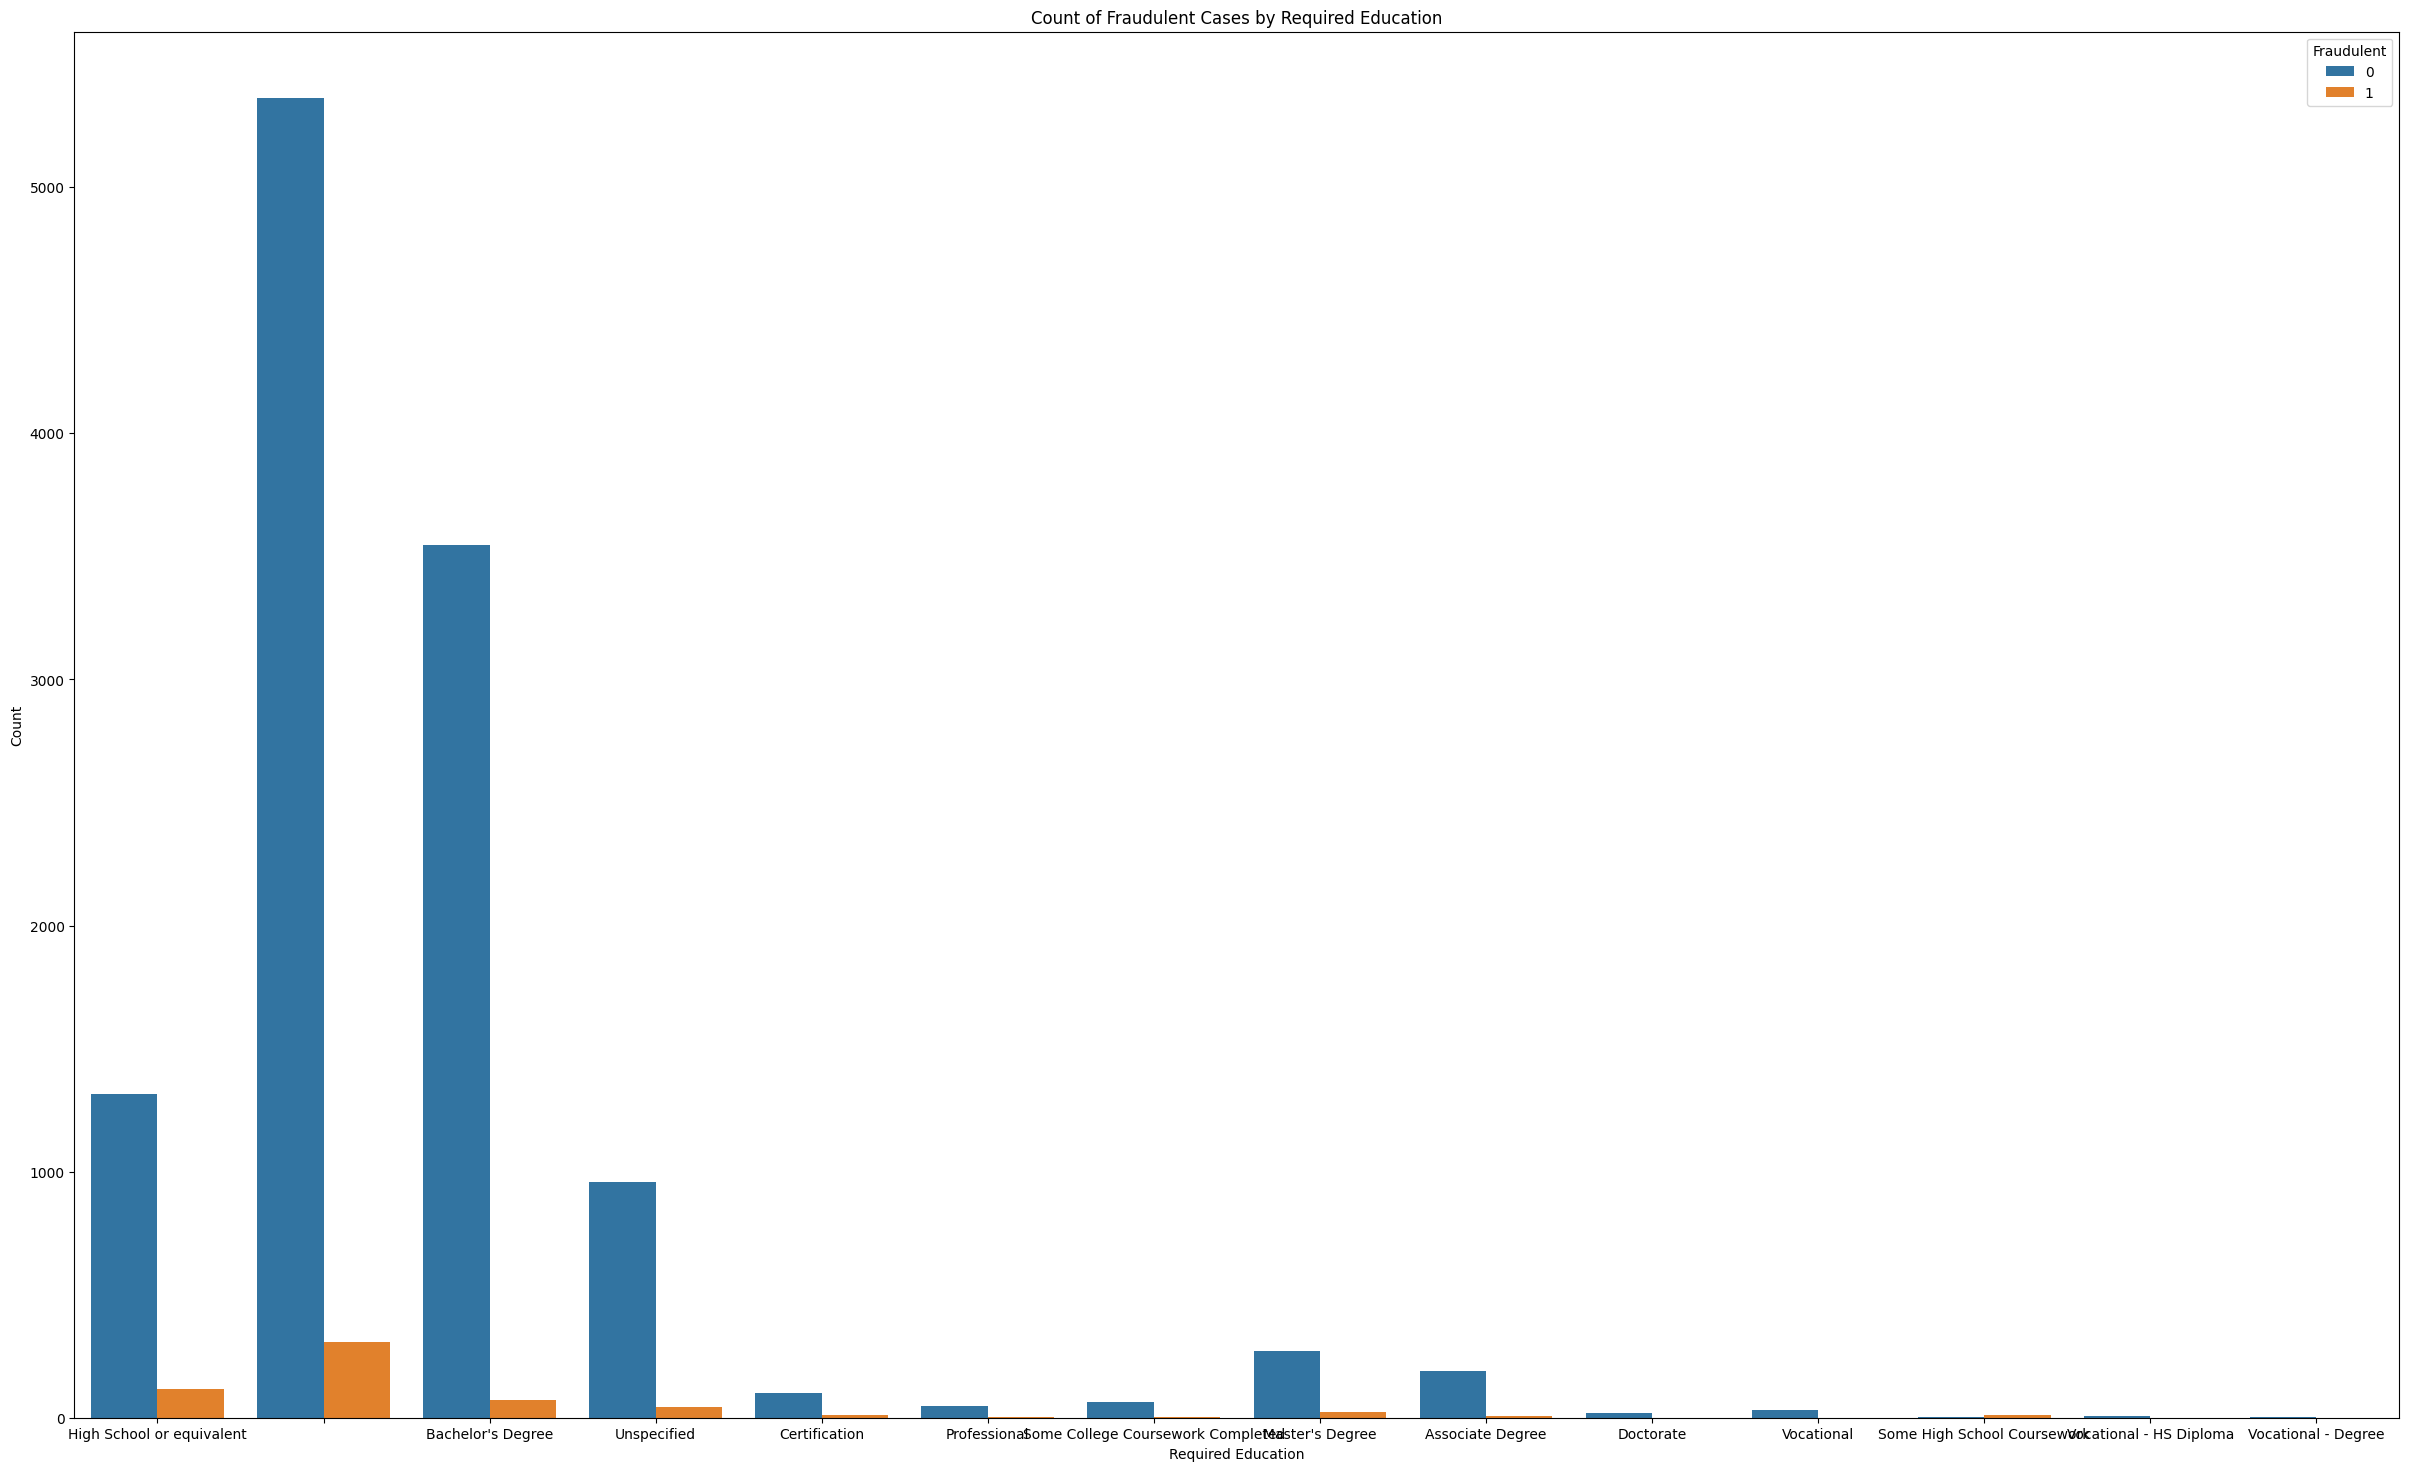

In [26]:
# 대상 클래스와 필수 교육 사이에 관계가 있는지 확인
plt.figure(figsize=(30, 18))
sns.countplot(data=train, x='required_education', hue='fraudulent')
plt.title('Count of Fraudulent Cases by Required Education')
plt.xlabel('Required Education')
plt.ylabel('Count')
plt.legend(title='Fraudulent')
plt.show()

## **(3) 데이터 전처리**

### **1) 기본 데이터 전처리**

#### **Concatenate**
- 여러 텍스트 열을 하나의 text 열로 합치고, 그 외의 불필요한 열들을 삭제하여 데이터를 정리하고 준비

In [27]:
def concatenate(data):
    """
    주어진 데이터프레임에서 텍스트 열을 합치고 필요없는 열을 삭제하는 함수입니다.

    Args:
        data (pd.DataFrame): 합칠 데이터프레임
    
    Args:
        data (pd.DataFrame): 전처리할 데이터가 포함된 pandas DataFrame. 필수 컬럼: 'title', 'department', 'company_profile',
                             'description', 'requirements', 'benefits'.

    Returns:
        pd.DataFrame: 텍스트 열이 합쳐진 후 필요없는 열이 삭제된 데이터프레임
    """
    # (2-1) 데이터프레임의 각 텍스트 열을 하나의 텍스트 열로 합칩니다.
    data = data.copy()
    data.loc[:, 'text'] = data['title'] + ' ' + data['department'] + ' ' + data['company_profile'] + ' ' + data['benefits'] + ' '+ data['description'] + ' ' + data['requirements']
    
    # (2-2) 삭제할 열 목록 정의
    delete_list = ['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function']
    
    # (2-3) 데이터프레임에서 삭제할 열을 삭제합니다. (drop 함수 이용)
    data = data.drop(columns = delete_list)
    
    return data

### **텍스트 데이터 정제**
1. 줄 바꿈, 캐리지 리턴, 탭 제거 :

    - \n, \r, \t와 같은 특수 문자는 일반적으로 텍스트 처리 시 불필요한 경우가 많다. 

    - 이를 제거하여 텍스트를 깔끔하게 만든다.

2. 숫자 제거 :

    - 텍스트 데이터에서 숫자는 주로 의미를 가지지 않는 경우가 많다. 

    - 따라서 숫자를 제거하여 텍스트의 일관성을 유지한다.

3. 특수 문자 공백으로 대체 :

    - [/(){}\[\]\|@,;.:-]와 같은 특수 문자는 자연어 처리 모델에 있어서는 주로 불필요한 경우가 많다. 

    - 이를 공백으로 대체하여 단어들이 제대로 분리되도록 한다.

4. 텍스트를 소문자로 변환 :

    - 텍스트의 일관성을 유지하기 위해 모든 문자를 소문자로 변환한다. 
    
    - 대소문자의 구분은 자연어 처리 모델에서는 의미가 달라질 수 있기 때문에 일반적으로 소문자로 통일한다.

5. 불필요한 공백 제거 :

    - 전처리 과정에서 생길 수 있는 연속된 공백을 하나의 공백으로 줄인다.

In [28]:
def text_preprocessing(document):
    """
    주어진 텍스트 데이터를 전처리하는 함수.

    Args:
        document (pd.Series): 전처리할 텍스트 데이터가 포함된 pandas Series

    Returns:
        pd.Series: 전처리가 완료된 텍스트 데이터가 포함된 pandas Series
    """
    # (3-1) 줄 바꿈(\n), 캐리지 리턴(\r) 및 탭(\t)을 제거
    document = pd.Series([re.sub("\n", "", item) for item in document])
    document = pd.Series([re.sub("\r", "", item) for item in document])
    document = pd.Series([re.sub("\t", "", item) for item in document])
    
    # (3-2) 숫자를 제거
    document = pd.Series([re.sub("[0-9]+", "", item) for item in document])
    
    # (3-3) 특수 문자를 공백으로 대체
    document = pd.Series([re.sub("[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]", " ", item) for item in document])
    
    # (3-4) 텍스트를 소문자로 변환
    document = pd.Series([item.lower() for item in document])
    
    # (3-5) 불필요한 공백 제거
    document = pd.Series([" ".join(item.split()) for item in document])
    
    
    return document

### **불용어 제거**
- 자연어 처리에서 처리하지 않거나 제거하는 단어들을 말한다. 

- 이러한 단어들은 문장에서 주로 등장하지만 분석에 있어서는 일반적으로 정보를 제공하지 않거나 미미한 역할을 하는 경우가 많다. 

- 따라서 이러한 불용어들을 제거함으로써 텍스트 데이터의 처리나 분석 성능을 개선할 수 있다.

- 보통의 불용어 목록에는 다음과 같은 단어들이 포함될 수 있다:

    - **영어**: "a", "an", "the", "in", "on", "at", "to" 등

    - **한국어**: "을", "를", "이", "가", "은", "는", "에서", "에서는" 등

- 이러한 단어들은 문법적으로 필수적이거나 의미를 구체적으로 전달하지 않는 경우가 많다. 

- 예를 들어, "the"는 문장에서 주로 등장하지만 분석에 있어서는 거의 항상 무시할 수 있는 단어이다. 

- 또한, 이러한 단어들이 많이 사용될수록 문장의 길이는 더 길어지며, 분석에 방해가 될 수 있다.

In [29]:
def remove_stopwords(document, nlp):
    """
    주어진 텍스트 데이터에서 불용어를 제거하는 함수.

    Args:
        document (pd.DataFrame): 전처리할 텍스트 데이터가 있는 pandas DataFrame. 'text' 열이 필요합니다.
        nlp (spacy.lang.en.English): Spacy에서 로드한 영어 언어 모델 객체.

    Returns:
        pd.DataFrame: 불용어가 제거된 텍스트 데이터가 포함된 pandas DataFrame.
    """
    # (4) 불용어 제거
    # 주어진 document DataFrame의 'text' 열에서 각 문서에 대해 처리를 수행.
    # 각 문서는 공백을 기준으로 단어로 분할(split)하고, 불용어가 아닌 단어들로 구성된 리스트를 생성.
    # 이 리스트는 다시 공백을 사이에 두고 join하여 하나의 문자열로 만든다.
    # 이후 이 문자열을 'text' 열에 대입하여 각 문서의 전처리 결과를 업데이트.
    
    for step, sentence in enumerate(document['text']):
        list = []
        for token in nlp(sentence):
            if not token.is_stop:
                list.append(token.text)
        document.loc[step, 'text'] = " ".join(list)
    
    return document

### **어간 추출(Stemming) 및 표제어 추출(Lemmatization)**
- 두 기법 모두 자연어 처리에서 텍스트 전처리 과정 중에 단어의 원형을 찾는 데 사용.

- 일반적으로 표제어 추출은 어간 추출보다 정교하고 문맥을 잘 이해하는 방식이기 때문에, 자연어 처리에서 더 많이 사용.<br><br>

- **어간 추출** : 단순한 접미사 제거 방식으로 단어의 어간을 추출. 결과는 사전에 있는 단어가 아닐 수 있다.

- **표제어 추출** : 문법적, 의미적으로 올바른 표준 형태의 단어를 추출. 결과는 사전에 등재된 실제 단어.<br><br>

1. **어간 추출 (Stemming)** : 

    - 어간 추출은 단어의 어간(stem)만 남기고 접사(suffix)를 제거하여 단어의 기본 형태를 찾는 과정.

    - 예를 들어, "running", "runs", "runner"는 모두 "run"이라는 어간을 가지고 있다. 따라서 어간 추출은 이들을 모두 "run"으로 축소.

    - 어간 추출은 단순히 규칙 기반의 접미사 제거 방식이기 때문에, 결과로 나오는 단어는 실제 사전에 있는 단어일 필요는 없고, 때로는 일반적이지 않은 형태일 수 있다.<br><br>


2. **표제어 추출 (Lemmatization)** :

    - 표제어 추출은 단어의 표준 형태인 표제어(lemma)를 찾는 과정입니다.

    - 표제어는 사전에 등재된 실제 단어. 예를 들어, "running"의 표제어는 "run", "better"의 표제어는 "good"입니다.

    - 표제어 추출은 단어의 문맥을 고려하고, 형태소 분석(morphological analysis)을 수행하여 단어의 형태와 문법적 의미를 이해한 후에 추출.

    - 따라서 표제어 추출은 언어적, 문법적 규칙을 적용하여 단어를 정규화하는 과정.

In [30]:
# 7~10분 소요
def lemmatize_text(document, nlp):
    """
    주어진 텍스트 데이터에 대해 Spacy 모델을 사용하여 각 단어의 기본형을 추출하는 함수.

    Args:
        document (pd.Series): 전처리할 텍스트 데이터가 포함된 pandas Series.
        nlp (spacy.lang.en.English): Spacy에서 로드한 영어 언어 모델 객체.

    Returns:
        pd.Series: 전처리가 완료된 텍스트 데이터가 포함된 pandas Series.
    """
    # (5) 표제어 추출
    # Spacy 모델인 nlp를 사용하여 텍스트를 토큰화.
    # 각 토큰의 기본형(lemma)을 추출하여 리스트로 변환.
    # 추출된 기본형들을 공백을 사이에 두고 하나의 문자열로 결합.
    # 최종적으로 각 텍스트 데이터의 단어들이 기본형으로 변환된 후의 문자열이 포함된 pandas Series를 반환.
    
    for step, sentence in enumerate(document):
        list = []
        for token in nlp(sentence):
            list.append(token.lemma_)
            #print(token.lemma_)
        #print(list)
        document = document.copy()
        document.loc[step] = " ".join(list)
            

    return document

#### **종합**
- concatenate -> 텍스트 데이터 정제 -> 불용어 제거 -> 표제어 추출

In [31]:
def preprocessing(data):
    """
    주어진 데이터프레임을 전처리하는 함수입니다.

    Args:
        data (pd.DataFrame): 전처리할 데이터가 포함된 pandas DataFrame. 필수 컬럼: 'title', 'department', 'company_profile',
                             'description', 'requirements', 'benefits'.

    Returns:
        pd.DataFrame: 전처리된 데이터가 포함된 pandas DataFrame.
    """
    # 영어 언어 모델 'en_core_web_sm'을 로드다.
    nlp = spacy.load("en_core_web_sm")
    
    # (6-1) 데이터프레임의 각 텍스트 열을 하나의 텍스트 열로 합침.
    data = concatenate(data)
    
    # (6-2) 텍스트 데이터 전처리를 수행.
    data.loc[:, 'text'] = text_preprocessing(data.loc[:, 'text'])
    
    # (6-3) 불용어를 제거.
    data.loc[:, 'text'] = remove_stopwords(data, nlp)
    
    # (6-4) 각 단어를 기본형으로 변환하여 텍스트를 정제.
    data.loc[:, 'text'] = lemmatize_text(data.loc[:, 'text'],nlp)
    
    return data

In [32]:
# 10 ~ 15분 소요
train = preprocessing(train)
test = preprocessing(test)

In [33]:
train

,fraudulent,text
0,0,mystery shopper sdi marketing start small mark...
1,0,intern ve build revolutionary technology chang...
2,0,talent acquisition specialist usa people opera...
3,0,chief operating officer marketinvoice high pro...
4,0,client manager found daniel tenner paulina syg...
...,...,...
12511,0,digital procurement assistant hayes corp creat...
12512,0,city project manager mission make city smart c...
12513,0,inside sales rep qb medical inc medical supply...
12514,0,retail territory merchandiser cpg industry sto...


In [34]:
test

,text
0,python engineer negotiable salary potential eq...
1,entry level sale great health dentalfast advan...
2,agile project manager ustwo offer opportunity ...
3,marketing coordinator business marketing build...
4,stack web engineer runscope building tool deve...
...,...
5359,work student internal support engineer enginee...
5360,associate business development want build care...
5361,graduate english teacher abroad conversational...
5362,embed application engineer communication stack...


### **※ 워드 클라우드 (Word Cloud)**
- 텍스트 데이터에서 가장 빈도가 높은 단어들을 시각적으로 표현하여, 단어의 중요도를 직관적으로 파악할 수 있게 해주는 시각화 기법. 

- 주어진 텍스트 데이터에서 각 단어의 출현 빈도를 분석하여, 빈도가 높은 단어일수록 크고, 낮은 단어일수록 작게 표현하는 형태로 만듬.

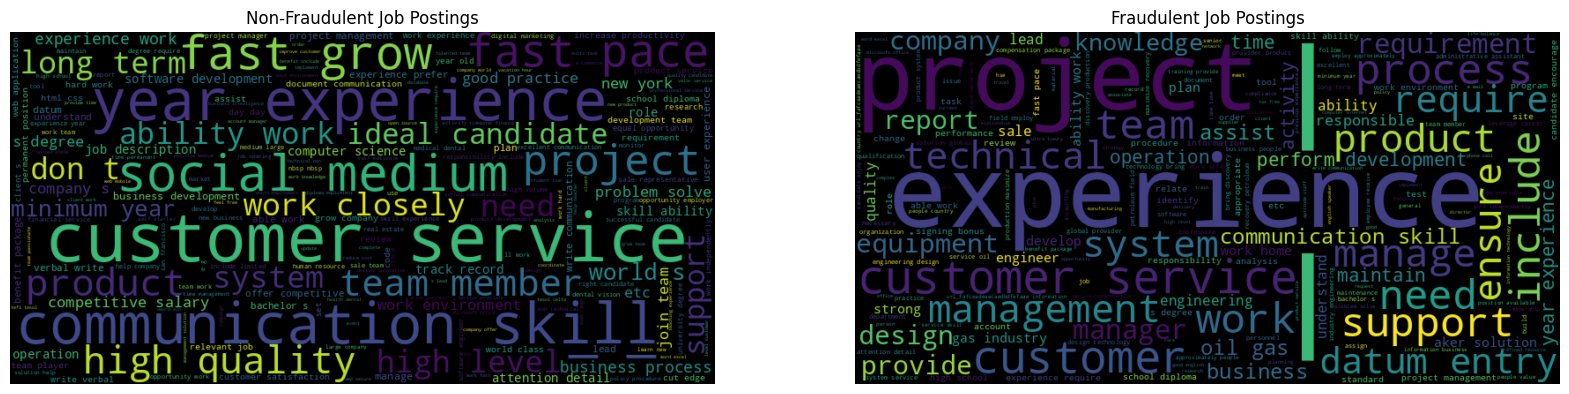

In [35]:
# 실제 잡포스팅 텍스트를 하나의 문자열로 결합
non_fraudulent_text = ' '.join(text for text in train[train['fraudulent'] == 0]['text'])

# 가짜 잡포스팅 텍스트를 하나의 문자열로 결합
fraudulent_text = ' '.join(text for text in train[train['fraudulent'] == 1]['text'])

# 실제 잡포스팅 텍스트의 워드클라우드 생성
wordcloud_non_fraudulent = WordCloud(width=800, height=400, background_color='black').generate(non_fraudulent_text)

# 가짜 잡포스팅 텍스트의 워드클라우드 생성
wordcloud_fraudulent = WordCloud(width=800, height=400, background_color='black').generate(fraudulent_text)

# 두 개의 서브플롯을 가지는 Figure 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# 첫 번째 서브플롯에 진짜 잡포스팅 워드클라우드 표시
ax1.imshow(wordcloud_non_fraudulent, interpolation='bilinear')
ax1.axis('off')  # 축 숨기기
ax1.set_title('Non-Fraudulent Job Postings')

# 두 번째 서브플롯에 가짜 잡포스팅 워드클라우드 표시
ax2.imshow(wordcloud_fraudulent, interpolation='bilinear')
ax2.axis('off')  # 축 숨기기
ax2.set_title('Fraudulent Job Postings')

# 워드클라우드 시각화 표시
plt.show()

### **2) BERT 모델 입력을 위한 데이터 전처리**

#### **스페셜 토큰 붙이기**
- BERT(Bidirectional Encoder Representations from Transformers)에서는 특별한 몇 가지 토큰이 있다. 

- 이들 특별 토큰은 BERT 모델이 입력 시퀀스의 시작과 끝, 패딩, 문장 구분 등을 인식하도록 돕는다.<br><br>

- 주요 스페셜 토큰은 다음과 같다:
    1. **[CLS] 토큰**
        - Classification을 위한 토큰.

        - BERT 모델은 입력 시퀀스의 처음에 [CLS] 토큰을 추가하고, 이 위치의 은닉 상태를 활용하여 분류 작업 등에 사용.
        
    2. **[SEP] 토큰**
        - 문장 구분을 위한 토큰. 

        - BERT 모델은 두 개의 문장을 구분할 때 [SEP] 토큰을 사용하여 두 문장을 구분. 또한, 입력 시퀀스의 끝에도 [SEP] 토큰이 추가.

In [36]:
def add_special_token(document):
    """
    입력된 문서(문장 리스트)에 BERT 특수 토큰 [CLS]와 [SEP]을 추가하는 함수.

    Args:
        document (list): 문장들이 포함된 리스트.

    Returns:
        list: BERT 특수 토큰 [CLS]와 [SEP]이 추가된 문장들의 리스트.
    """
    added = ["[CLS]" + str(sentence) + "[SEP]" for sentence in document]
    
    return added

In [37]:
sample_list = train.head().loc[:, 'text'].values
#add_special_token(sample_list)

#### **토큰화(Tokenization)**
- 토큰화는 텍스트를 작은 단위로 나누는 과정을 말한다. 

- 이 작은 단위는 일반적으로 <U>토큰(Token)</U>이라고 부른다. 

- 토큰은 문장을 구성하는 최소 단위로, 예를 들어 단어, 숫자, 문장부호 등이 될 수 있다. 

- 토큰화는 텍스트 데이터를 모델이 이해할 수 있는 형태로 변환하는 첫 단계.<br><br>

- 예시:
    - 입력 텍스트: "Hello, how are you?"
    
    - 토큰화 결과: ["Hello", ",", "how", "are", "you", "?"]<br><br>

- 자연어 처리 모델은 보통 토큰화된 단어들을 입력으로 받아 처리. 

- 토큰화는 단순히 공백을 기준으로 나누는 것 이상의 복잡한 규칙을 적용할 수 있다. 

- 예를 들어, 문장부호 처리, 대소문자 통일, 특수 문자 처리 등이 포함될 수 있다.


In [38]:
def tokenization(data):
    """
    입력된 데이터를 BERT 토크나이저를 사용하여 토큰화하고, 토큰을 정수 인덱스로 변환하는 함수.

    Args:
        data (list): 토큰화할 문장들이 포함된 리스트.

    Returns:
        list: 각 문장을 정수 인덱스로 변환한 결과 리스트(ids).
    """
    # (7-1) BERT 토크나이저 초기화 (bert-base-multilingual-cased 모델 사용)
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    
    # (7-2) 각 문장을 토큰화
    tokenized = [tokenizer.tokenize(item) for item in data]
    
    # (7-3) 토큰을 정수 인덱스로 변환
    ids = [tokenizer.convert_tokens_to_ids(item) for item in tokenized]
    
    return ids


In [39]:
sample_list = train.head().loc[:, 'text'].to_list()
# tokenization(sample_list)

#### **패딩(padding)**
- 패딩은 입력 데이터의 길이를 맞추는 과정을 말한다. 

- 특히 자연어 처리에서는 모든 입력 데이터가 동일한 길이를 가져야 하는 경우가 많다. 

- 이를 위해 길이가 짧은 문장에는 패딩 토큰을 추가하여 전체 데이터셋의 입력 길이를 통일시키는 작업을 수행.<br><br>

- 패딩은 일반적으로 0이나 다른 특정한 값으로 채워진 토큰을 추가하는 방식으로 이루어진다. 

- 이러한 패딩 과정은 모델이 배치(batch) 단위로 데이터를 처리할 때 효율적으로 동작할 수 있도록 한다.<br><br>

- 예시:

    - 입력 문장들: ["I", "am", "fine"], ["How", "are", "you", "?"]

    - 패딩 후 결과: ["I", "am", "fine", 0], ["How", "are", "you", "?"]
    
- 여기서 패딩을 추가할 때 주의할 점은 최대 길이를 정하고 그 이하의 문장에 패딩을 추가하는 것. 너무 긴 문장은 잘라내거나 특정 길이로 자를 수도 있다.<br><br>

- 토큰화와 패딩은 모델이 텍스트 데이터를 이해하고 처리할 수 있도록 데이터를 준비하는 중요한 단계. 
- 이 두 가지 과정은 대부분의 자연어 처리 모델에서 필수적으로 적용됨.

In [40]:
def padding(ids, args):
    """
    입력된 정수 시퀀스(ids)들을 패딩하여 모든 시퀀스가 동일한 길이가 되도록 만드는 함수.

    Args:
        ids (list of list): 패딩할 정수 시퀀스들이 포함된 리스트.
        args (dict): 패딩에 사용할 매개변수들을 포함한 사전.

    Returns:
        list of list: 패딩된 정수 시퀀스들의 리스트.
    """
    # default padding_value is 0
    ids = pad_sequences(ids, maxlen=args["max_len"], dtype="long", truncating='post', padding='post').tolist()
    
    return ids


In [41]:
"""
sample_list = train.head().loc[:, 'text'].to_list()
sample_list = tokenization(sample_list)
sample_list = padding(sample_list,args)
len(sample_list), type(sample_list[0])
"""

"\nsample_list = train.head().loc[:, 'text'].to_list()\nsample_list = tokenization(sample_list)\nsample_list = padding(sample_list,args)\nlen(sample_list), type(sample_list[0])\n"

In [42]:
#print(sample_list[0])
#print(sample_list[1])

#### **어텐션 마스팅**
- 어텐션 마스킹(Attention Masking)은 자연어 처리에서 Transformer 모델과 같은 어텐션 기반 모델에서 사용되는 중요한 개념.

- 이는 모델이 입력 시퀀스에서 각 토큰 간의 관계를 학습할 때, 불필요한 관계를 제거하거나 유용한 관계를 강조하는 메커니즘.

In [43]:
def attention_mask(ids):
    """
    입력된 정수 시퀀스들에 대한 어텐션 마스크를 생성하는 함수.

    Args:
        ids (list of list): 정수 시퀀스들이 포함된 리스트.

    Returns:
        list of list: 어텐션 마스크 리스트. 토큰이 있는 부분은 1, 없는 부분은 0으로 설정됨.
    """
    masks = []
    
    for id in ids:
        # (8-1) 토큰이 있는 부분은 1, 없는 부분은 0으로 설정
        mask = [1 if token > 0 else 0 for token in id]
        
        # (8-2) 생성된 마스크를 마스크 리스트에 추가
        masks.append(mask)
        
    return masks


#### **종합**
- 스페셜 토큰 추가 -> 분절화(토큰화) -> 패딩 -> 마스킹 과정

In [44]:
def bert_preprocessing(data, args):
    """
    BERT 입력을 준비하기 위한 전처리 함수.

    Args:
        data (DataFrame): 전처리할 데이터가 포함된 pandas DataFrame.
        args (dict): 전처리 과정에서 사용할 인자들이 포함된 딕셔너리.

    Returns:
        DataFrame: BERT 입력을 준비한 후의 데이터프레임.
    """
    # (9-1) 특수 토큰 추가 함수 호출
    # document(list)
    document = add_special_token(data['text'].to_list())
    
    # (9-2) 토큰화 함수 호출하여 텍스트를 토큰 ID로 변환
    #ids : list
    ids = tokenization(document)
    
    # (9-3) 패딩 함수 호출하여 모든 시퀀스의 길이를 일치시킴
    ids = padding(ids, args)
    
    # (9-4) 어텐션 마스크 생성 함수 호출
    # masks : list
    masks = attention_mask(ids)
    
    # (9-1) 데이터프레임에 토큰 ID 및 어텐션 마스크 열 추가
    data['id'] = ids
    data['mask'] = masks
    
    # 메모리에서 불필요한 변수 삭제
    del document, ids, masks
    
    # 처리된 데이터 반환
    return data


In [45]:
train = bert_preprocessing(train, args)
test = bert_preprocessing(test, args)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [46]:
train

,fraudulent,text,id,mask
0,0,mystery shopper sdi marketing start small mark...,"[101, 84058, 39090, 12713, 187, 10703, 29465, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,0,intern ve build revolutionary technology chang...,"[101, 90598, 10323, 23332, 71270, 19765, 15453...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,0,talent acquisition specialist usa people opera...,"[101, 27411, 41714, 64956, 15610, 11426, 20080...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,0,chief operating officer marketinvoice high pro...,"[101, 19421, 24210, 19288, 17313, 10245, 44927...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,0,client manager found daniel tenner paulina syg...,"[101, 37748, 16935, 11823, 10215, 19428, 11769...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...
12511,0,digital procurement assistant hayes corp creat...,"[101, 16924, 11284, 55888, 10426, 20999, 13605...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
12512,0,city project manager mission make city smart c...,"[101, 11584, 13920, 16935, 17032, 13086, 11584...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
12513,0,inside sales rep qb medical inc medical supply...,"[101, 22978, 23857, 76456, 185, 10457, 19436, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
12514,0,retail territory merchandiser cpg industry sto...,"[101, 52232, 24399, 13697, 47019, 103845, 1012...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [47]:
test

,text,id,mask
0,python engineer negotiable salary potential eq...,"[101, 184, 96362, 10263, 26500, 21134, 16180, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,entry level sale great health dentalfast advan...,"[101, 14722, 13277, 15488, 14772, 17004, 10859...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,agile project manager ustwo offer opportunity ...,"[101, 16942, 12808, 13920, 16935, 19626, 43921...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,marketing coordinator business marketing build...,"[101, 29465, 11170, 72397, 14155, 29465, 23332...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,stack web engineer runscope building tool deve...,"[101, 16527, 11263, 12998, 26500, 17913, 84087...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...
5359,work student internal support engineer enginee...,"[101, 11424, 16470, 29868, 13145, 26500, 25008...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5360,associate business development want build care...,"[101, 46175, 14155, 13405, 21528, 23332, 13021...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5361,graduate english teacher abroad conversational...,"[101, 32893, 20207, 15529, 24996, 50901, 72028...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5362,embed application engineer communication stack...,"[101, 10266, 33627, 19800, 26500, 24990, 16527...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


# **2. 데이터셋과 데이터로더**
참고 : https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset

In [48]:
# train 데이터와 validation 데이터로 분리
train, valid = train_test_split(train, test_size=0.1)

# TensorDataset을 사용하여 데이터셋 생성
train_dataset = TensorDataset(torch.tensor(train['id'].tolist()), 
                              torch.tensor(train['mask'].tolist()), 
                              torch.tensor(train['fraudulent'].tolist()))
valid_dataset = TensorDataset(torch.tensor(valid['id'].tolist()), 
                              torch.tensor(valid['mask'].tolist()), 
                              torch.tensor(valid['fraudulent'].tolist()))
test_dataset = TensorDataset(torch.tensor(test['id'].tolist()), 
                             torch.tensor(test['mask'].tolist()))

# DataLoader를 사용하여 데이터를 배치 단위로 로드
train_dataloader = DataLoader(train_dataset, batch_size=args["batch_size"], sampler = RandomSampler(train_dataset))
valid_dataloader = DataLoader(valid_dataset, batch_size=args["batch_size"], sampler = RandomSampler(valid_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=1, sampler = SequentialSampler(test_dataset))


# **3. 모델**
BERT 모델을 정의하고, 사전 훈련된 가중치 로드하세요.

In [49]:
# (11) BERT 모델 정의 및 사전 훈련된 가중치 로드
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')

model = model.to(device)
print(model)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

# **4. 학습**

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6


100%|██████████| 40/40 [03:32<00:00,  5.32s/it]


CheckPoint : model_state_dict_epoch_1.pth
train_loss : 0.195579637987645, train_acc : 0.9411399147727273

valid_loss : 0.12734020045027136, valid_acc : 0.75

Epoch 2/6


100%|██████████| 40/40 [03:31<00:00,  5.30s/it]


CheckPoint : model_state_dict_epoch_2.pth
train_loss : 0.07434674659618229, train_acc : 0.9806463068181818

valid_loss : 0.06244982510106638, valid_acc : 1.0

Epoch 3/6


100%|██████████| 40/40 [03:33<00:00,  5.34s/it]


CheckPoint : model_state_dict_epoch_3.pth
train_loss : 0.034624750705916085, train_acc : 0.9913884943181818

valid_loss : 0.05771711136767408, valid_acc : 1.0

Epoch 4/6


100%|██████████| 40/40 [03:32<00:00,  5.31s/it]


CheckPoint : model_state_dict_epoch_4.pth
train_loss : 0.015743187877143846, train_acc : 0.9960049715909091

valid_loss : 0.07361207108042436, valid_acc : 1.0

Epoch 5/6


100%|██████████| 40/40 [03:32<00:00,  5.31s/it]


CheckPoint : model_state_dict_epoch_5.pth
train_loss : 0.007260130741666548, train_acc : 0.9982244318181818

valid_loss : 0.0904594247796922, valid_acc : 1.0

Epoch 6/6


100%|██████████| 40/40 [03:33<00:00,  5.35s/it]


CheckPoint : model_state_dict_epoch_6.pth
train_loss : 0.002459220141810709, train_acc : 0.9994673295454546

valid_loss : 0.08874384304508567, valid_acc : 1.0



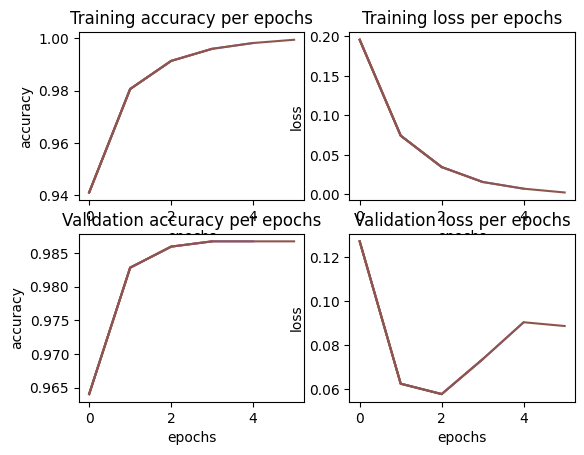

In [50]:
def train(train_dataloader, valid_dataloader, model, device, args):
    """
    주어진 데이터로 모델을 학습시키는 함수.

    Args:
        train_dataloader (DataLoader): 학습 데이터를 제공하는 DataLoader 객체
        valid_dataloader (DataLoader): 검증 데이터를 제공하는 DataLoader 객체
        model (torch.nn.Module): 학습할 모델
        device (torch.device): 사용할 디바이스 (CPU 또는 GPU)
        args (dict): 학습 관련 인자들을 포함한 딕셔너리

    Returns:
        None
    """
    acc_list = []
    loss_list = []
    val_acc_list = []
    val_loss_list = []
    
    
    # (12-1) 옵티마이저와 스케줄러 초기화
    optimizer = AdamW(params=model.parameters(), lr = args['lr'], weight_decay=0.01, eps=args['eps'])
    
    train_len = len(train_dataloader)
    num_training_steps = train_len * args['epochs']
    num_warmup_steps = int(num_training_steps * 0.1)
    
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps= num_training_steps)
    
    # (12-2) 모델의 그래디언트 초기화
    model.zero_grad()
    
    for epoch in range(args["epochs"]):
        # (12-3) 모델을 훈련 모드로 설정
        model.train()
        
        total_loss = 0  # 전체 손실 초기화
        total_accuracy = 0  # 전체 정확도 초기화
        
        print(f'Epoch {epoch + 1}/{args["epochs"]}')
        
        for step, batch in enumerate(tqdm(train_dataloader)):
            batch = tuple(index.to(device) for index in batch)
            ids, masks, labels = batch
            
            # (12-4) Forward pass
            outputs = model(input_ids = ids, attention_mask = masks, labels = labels)
            
            # (12-5) 손실 계산
            loss = outputs.loss
            
            # 손실 누적
            total_loss += loss.item()
            
            # 정확도 계산
            pred = [torch.argmax(logit).cpu().detach().item() for logit in outputs.logits]
            true = [label for label in labels.cpu().numpy()]
            accuracy = accuracy_score(true, pred)
            total_accuracy += accuracy
            
            # (12-6) Backward pass
            loss.backward()
            
            # 그래디언트 클리핑
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            # (12-7) 옵티마이져를 이용한 파라미터 업데이트
            optimizer.step()
            
            # (12-8) 스케줄러로 러닝 레이트 업데이트
            scheduler.step()
            
            # (12-9) 모델의 그래디언트 초기화
            optimizer.zero_grad()
        
        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_acc = 0
            
            for val_step, val_batch in enumerate(tqdm(valid_dataloader)):
                val_batch = tuple(index.to(device) for index in val_batch)
                ids, masks, labels = val_batch
                
                val_outputs = model(input_ids = ids, attention_mask = masks, labels = labels)
                cur_loss = val_outputs.loss
                val_loss += cur_loss.item()
                
                val_pred = [torch.argmax(logit).cpu().detach().item() for logit in val_outputs.logits]
                val_true = [label for label in labels.cpu().numpy()]
                val_accuracy = accuracy_score(val_true, val_pred)
                val_acc += val_accuracy
            
            val_loss /= len(valid_dataloader)
            val_acc /= len(valid_dataloader)
            val_acc_list.append(val_acc)
            val_loss_list.append(val_loss)
            
        
        # 평균 손실과 정확도 계산
        avg_loss = total_loss / len(train_dataloader)
        avg_accuracy = total_accuracy / len(train_dataloader)
        
        acc_list.append(avg_accuracy)
        loss_list.append(avg_loss)
        
        # 모델 체크포인트 저장
        os.makedirs("results", exist_ok=True)
        """
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item,
            }, f'./results/model_state_dict_epoch_{epoch+1}.pth')
        """
            
        # 현재 에포크의 손실과 정확도 출력
        print(f'CheckPoint : model_state_dict_epoch_{epoch+1}.pth')
        print(f'train_loss : {avg_loss}, train_acc : {avg_accuracy}\n')
        print(f'valid_loss : {val_loss}, valid_acc : {val_accuracy}\n')

        plt.subplot(221)
        plt.plot(acc_list)
        plt.title('Training accuracy per epochs')
        plt.xlabel('epochs')
        plt.ylabel('accuracy')

        plt.subplot(222)
        plt.plot(loss_list)
        plt.title('Training loss per epochs')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        
        plt.subplot(223)
        plt.plot(val_acc_list)
        plt.title('Validation accuracy per epochs')
        plt.xlabel('epochs')
        plt.ylabel('accuracy')

        plt.subplot(224)
        plt.plot(val_loss_list)
        plt.title('Validation loss per epochs')
        plt.xlabel('epochs')
        plt.ylabel('loss')


if __name__ == "__main__":
    train(train_dataloader, valid_dataloader, model, device, args)

In [51]:
#checkpoint = torch.load("/kaggle/working/results/model_state_dict_epoch_9.pth", map_location=device)

#model.load_state_dict(checkpoint['model_state_dict'])

# **5. 평가**

In [52]:
def test(test_dataloader, model, device):
    """
    모델의 테스트를 수행하는 함수.

    Args:
        test_dataloader (DataLoader): 테스트 데이터를 제공하는 DataLoader 객체
        model (torch.nn.Module): 평가할 모델
        device (torch.device): 사용할 디바이스 (CPU 또는 GPU)

    Returns:
        preds (list): 각 입력 예시에 대한 모델의 예측 결과 리스트
    """
    # (13-1) 모델을 평가 모드로 설정
    
    preds = []  # 예측 결과를 저장할 리스트
    
    # 각 배치에 대해 예측 수행
    for batch in tqdm(test_dataloader):
        # (13-2) 배치의 데이터를 GPU로 이동
        batch = tuple(index.to(device) for index in batch)
        # (13-3) 입력 ID와 마스크를 추출
        ids, masks = batch
        
        # (13-4) 그래디언트 계산 비활성화
        with torch.no_grad():
            # (13-5) 모델에 입력을 전달하여 예측 수행
            output = outputs = model(input_ids = ids, attention_mask = masks)
            # (13-6) 예측 결과를 CPU로 이동하여 추출
            pred = torch.argmax(outputs.logits).cpu().detach().item()
            preds.append(pred)  # 예측 결과를 리스트에 추가
    
    return preds


if __name__ == "__main__":
    # 테스트 데이터로 예측 수행
    preds = test(test_dataloader, model, device)

100%|██████████| 5364/5364 [20:41<00:00,  4.32it/s]


In [53]:
submit = pd.read_csv(args["submit_path"])
submit

,job_id,fraudulent
0,4709,NaN
1,11080,NaN
2,12358,NaN
3,14512,NaN
4,16692,NaN
...,...,...
5359,15032,NaN
5360,1950,NaN
5361,8242,NaN
5362,15193,NaN


In [54]:
submit = pd.read_csv(args["submit_path"])
submit['fraudulent'] = preds
submit.to_csv('submission.csv', index=False)

In [55]:
submit

,job_id,fraudulent
0,4709,0
1,11080,0
2,12358,0
3,14512,0
4,16692,0
...,...,...
5359,15032,0
5360,1950,0
5361,8242,0
5362,15193,0


# **6. 추론(Inference)**

## **Gemini API 연결**

In [56]:
import google.generativeai as genai

def gemini(text):
    # (14-1) API 키 설정
    GOOGLE_API_KEY= 'your own api key'
    
    # (14-2) Google Generative AI 구성
    genai.configure(api_key=GOOGLE_API_KEY)

    # (14-3) GenerativeModel 인스턴스 생성
    model = genai.GenerativeModel('gemini-pro')
    
    # (14-4) 입력 텍스트를 사용하여 콘텐츠 생성
    response = model.generate_content(text)
    
    # 생성된 텍스트 출력
    print(response.text)

    return response.text

## **텍스트 생성**

In [57]:
# LLM에 입력될 문장
gemini_text = "Please create the following job very long posting phrase: 'We are looking for a dedicated and experienced software engineer to join our team. The ideal candidate will have strong problem-solving skills, extensive knowledge of programming languages, and experience in developing scalable applications. This position offers a competitive salary and a comprehensive benefits package."

In [58]:
# LLM에 문장 입력
text = gemini(gemini_text)

**Exceptional Software Engineer Wanted: Join Our Team of Innovators!**

Calling all brilliant minds! We are embarking on an exciting expedition to unearth a seasoned Software Engineer who possesses an insatiable thirst for problem-solving and a deep reverence for programming's intricate tapestry.

Your extraordinary skills in harnessing the power of programming languages will be the key to unlocking our company's true potential. We seek an individual who can masterfully wield these tools to craft scalable applications that will stand the test of time, empowering our organization to scale unparalleled heights.

To join our illustrious team, you must possess an unwavering commitment to excellence and a meticulous nature that ensures every line of code is a stroke of genius. Your ability to dissect complex problems, devise ingenious solutions, and execute them flawlessly will be the catalyst that propels our software to new frontiers of innovation.

Your contributions will be handsomely r

## **텍스트 데이터 전처리**

In [59]:
data = pd.DataFrame({'text': [text]})

In [60]:
# 기본 데이터 전처리
## 영어 언어 모델 'en_core_web_sm'을 로드합니다.
nlp = spacy.load("en_core_web_sm")

## 텍스트 데이터 전처리를 수행합니다.
data['text'] = text_preprocessing(data['text'])

## 불용어를 제거합니다.
data['text'] = remove_stopwords(data, nlp)

## 각 단어를 기본형으로 변환하여 텍스트를 정제합니다.
data['text'] = lemmatize_text(data['text'], nlp)

In [61]:
# BERT 모델 입력을 위한 데이터 전처리
## 특수 토큰 추가 함수 호출
document = add_special_token(data['text'])

## 토큰화 함수 호출하여 텍스트를 토큰 ID로 변환
ids = tokenization(document)

## 패딩 함수 호출하여 모든 시퀀스의 길이를 일치시킴
ids = padding(ids, args)

## 어텐션 마스크 생성 함수 호출
masks = attention_mask(ids)

## 데이터프레임에 토큰 ID 및 어텐션 마스크 열 추가
data['id'] = ids
data['mask'] = masks

## 메모리에서 불필요한 변수 삭제
del document, ids, masks

In [62]:
data

,text,id,mask
0,exceptional software engineer want join team i...,"[101, 30646, 10415, 16042, 26500, 21528, 23707...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## **추론**

In [63]:
def inference(data, model, device):
    """
    모델을 사용하여 단일 예제에 대해 추론을 수행하는 함수.

    Args:
        data (dict): 추론할 단일 예제 데이터 딕셔너리
        model (torch.nn.Module): 평가할 모델
        device (torch.device): 사용할 디바이스

    Returns:
        int: 예측된 클래스 레이블
    """
    # (15-1) 모델을 평가 모드로 설정
    model.eval()

    # (15-2) 데이터를 텐서로 변환하여 디바이스로 이동
    id = torch.tensor(data['id']).to(device)
    mask = torch.tensor(data['mask']).to(device)

    # (15-3) 그래디언트 계산 비활성화
    with torch.no_grad():
    
        # (15-4) 모델에 입력을 전달하여 예측 수행
        output = model(id, mask)
        pred = torch.argmax(output.logits).cpu().detach().item()

    return pred


if __name__ == "__main__":
    # 단일 예제에 대해 추론 수행
    predicted_label = inference(data, model, device)
    print(f"Job Posting : {data['text']}")
    print(f"Predicted Label : {predicted_label}")

Job Posting : 0    exceptional software engineer want join team i...
Name: text, dtype: object
Predicted Label : 0
